In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mpl_dates
import sys

sys.path.append("..")
from utils.modules import Asset
from utils.functions import simulate_gbm_ohlc
from utils.trend_line_optimizer import fit_trendlines_high_low


plt.rcParams['figure.figsize'] = [12, 7]

plt.rc('font', size=14) 


/Users/andrewcheam/Desktop/myProjects/TrendLine-Automation/env/lib/python3.11/site-packages/mpl_finance.py:16: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  __warnings.warn('\n\n  ================================================================='+


In [4]:
def get_smoothed_curve(close_df, bandwidth):
    #  Use Kernel Regression to create a fitted curve
    kernel_regression = KernelReg(
        [close_df.values], [close_df.index], var_type='c', bw=bandwidth)
    regression_result = kernel_regression.fit([close_df.index])
    # Get smoothed close prices
    smoothed_close_df = pd.Series(
        data=regression_result[0], index=close_df.index)
    return smoothed_close_df

In [5]:
symbol = "TSLA"
historical_data = pd.read_csv(f"../data/{symbol}_historical_data.csv")
historical_data['Date'] = pd.to_datetime(historical_data['Date'])
get_smoothed_curve(historical_data['Close'], )

TypeError: get_smoothed_curve() missing 1 required positional argument: 'bandwidth'

## Get the historical data

- Input the symbol in the dataloader script, which downloads the csv into data folder
- Saves the csv into historical_data df

In [2]:
symbol = "TSLA"
historical_data = pd.read_csv(f"../data/{symbol}_historical_data.csv")
historical_data['Date'] = pd.to_datetime(historical_data['Date'])

tsla = Asset(historical_data)

ValueError: cannot reshape array of size 868 into shape (124,1)

In [3]:
tsla.plot_candle()

NameError: name 'tsla' is not defined

## Create trend lines based on lowest / highest pivot point

- Find lowest/highest point on the graph (labelled as pivot)
- Create a linear trendline passing through the pivot, that has the least squared error to the price and does not touch any other point

### Pros
- Able to get accurate support and resistance trend lines for long term trends

### Cons
- Unable to negate outlier peaks and troughs

/Users/andrewcheam/Desktop/myProjects/TrendLine-Automation/src/../utils/modules.py:191: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


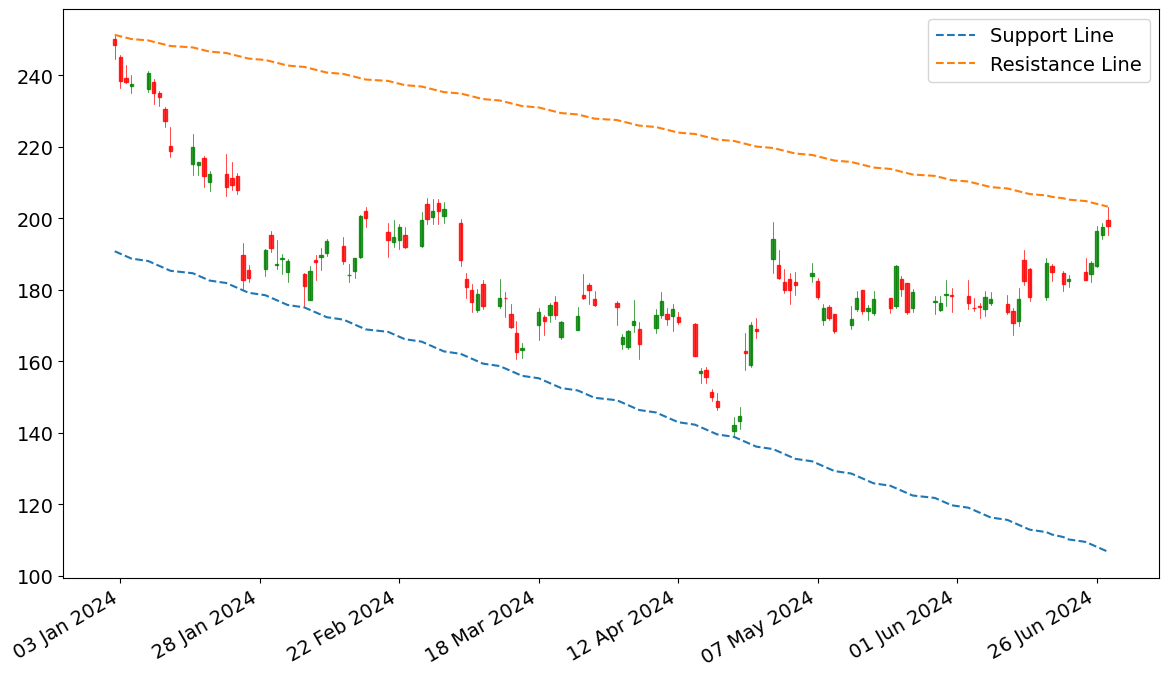

In [4]:
tsla.generate_pivot_trend_lines()

## Generating trend lines using fractal pattern for support and resistance

- Find support and resistance points using the idea of fractal pattern
- Create trend lines for each combination of 3 points using linear regression
- Rank trend lines based on std of their points and r2 value
- Choose top n trend lines to display on graph

### Pros
- Able to negate outlier peaks and troughs when plotting trend line
- The trend line is based on three supports / resistance, leading it to be tested and more reliable

### Cons
- Fractal pattern not 100% reliable to get support / resistance
- 

/Users/andrewcheam/Desktop/myProjects/TrendLine-Automation/src/../utils/modules.py:159: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


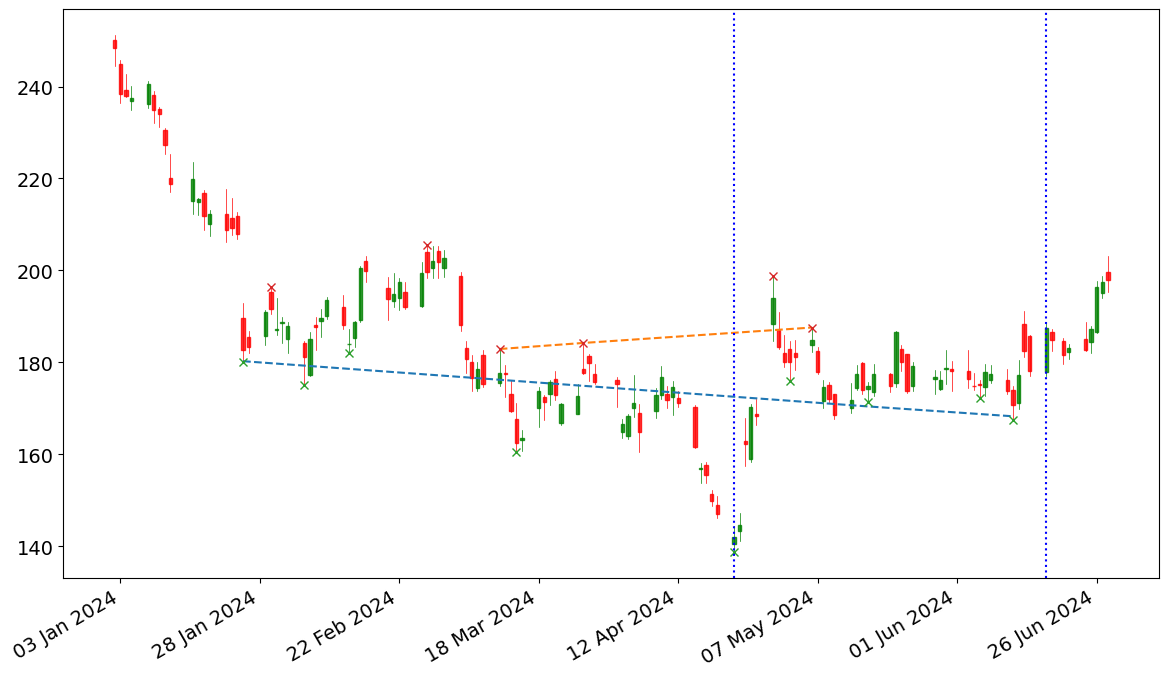

In [5]:
tsla.generate_fractal_trend_lines()


## Simulating a GBM

In [139]:
# Parameters
S0 = 100  # Initial price
mu = 0.05  # Drift
sigma = 0.2  # Volatility
T = 1.0  # 1 year
dt = 1/252  # Daily steps (assuming 252 trading days in a year)
N = 5  # Number of simulated paths

# Generate the OHLC data
ohlc_data = simulate_gbm_ohlc(S0, mu, sigma, T, dt, N)

# Example: Display the OHLC DataFrame for the first simulated path
ohlc_data[0].head()


,Open,High,Low,Close,Date
0,100.000000,100.804732,99.836060,100.639743,2023-01-02
1,100.055833,100.443172,99.968178,100.355255,2023-01-03
2,100.497468,100.740012,99.542095,99.782915,2023-01-04
3,100.464774,100.702691,98.855669,99.090331,2023-01-05
4,99.797056,101.098038,99.649810,100.949092,2023-01-06


/var/folders/t5/8fqbwc2d221c1h8pnz5m9nm40000gn/T/ipykernel_24285/2013907759.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


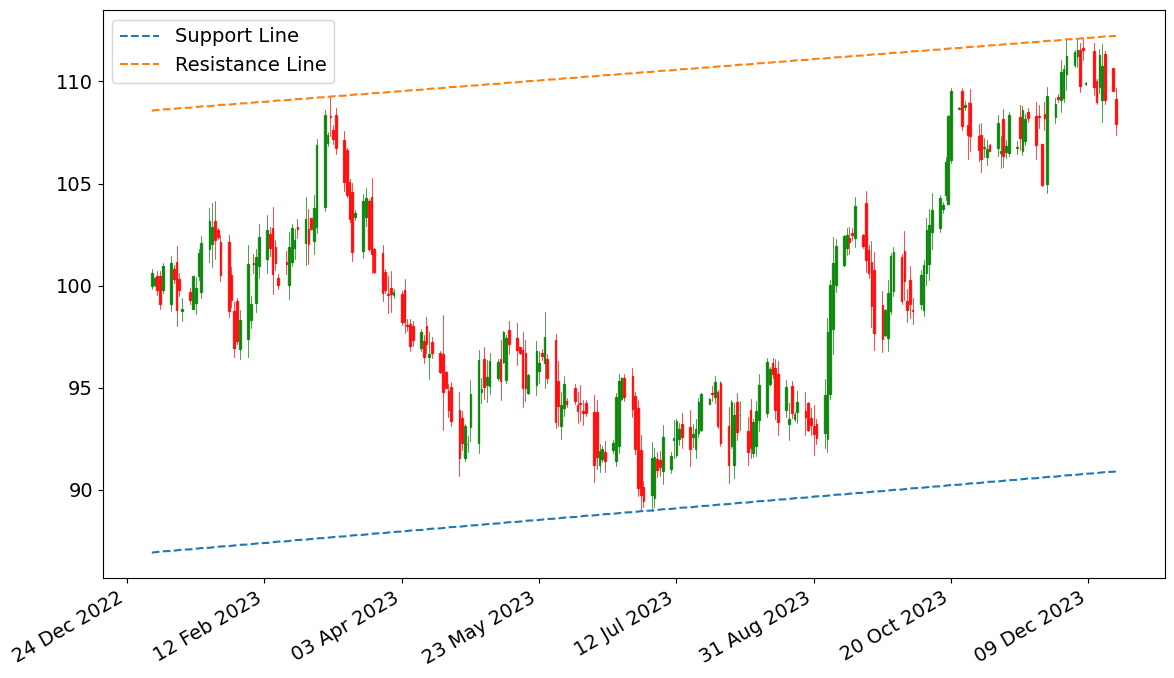

In [140]:
df = ohlc_data[0].copy()
support_coefs, resist_coefs = fit_trendlines_high_low(df['High'],df['Low'],df['Close'])
df['Date'] = df['Date'].apply(mpl_dates.date2num)

df = df.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]


fig, ax = plt.subplots()

candlestick_ohlc(ax,df.values,width=0.6, \
                colorup='green', colordown='red', alpha=0.8)


support_line = np.arange(len(df)) * support_coefs[0] + support_coefs[1]
resist_line = np.arange(len(df)) * resist_coefs[0] + resist_coefs[1]
plt.plot(df['Date'], support_line, label = "Support Line", linestyle = '--')
plt.plot(df['Date'], resist_line, label = "Resistance Line", linestyle = '--')
plt.legend()


date_format = mpl_dates.DateFormatter('%d %b %Y')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()

fig.tight_layout()
fig.show()

/var/folders/t5/8fqbwc2d221c1h8pnz5m9nm40000gn/T/ipykernel_24285/1987734694.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


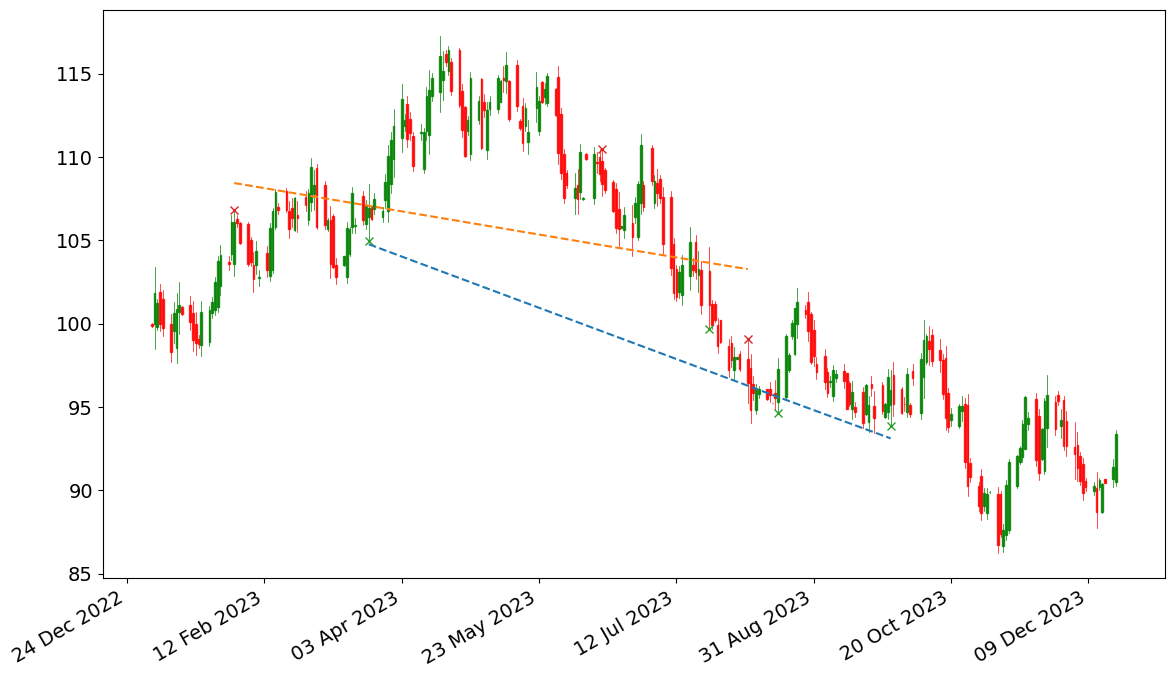

In [141]:
df = ohlc_data[1].copy()
supports, resistances, support_lines, resistance_lines = generate_fractal_trend_lines(df)

df['Date'] = df['Date'].apply(mpl_dates.date2num)

df = df.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]


fig, ax = plt.subplots()

candlestick_ohlc(ax,df.values,width=0.6, \
                colorup='green', colordown='red', alpha=0.8)
plt.plot(df['Date'][support_lines[0].x.flatten()], support_lines[0].y_pred, linestyle='--')
plt.plot(df['Date'][resistance_lines[0].x.flatten()], resistance_lines[0].y_pred, linestyle='--')


plt.plot(df['Date'][supports[:,0]], supports[:,1], 'x')
plt.plot(df['Date'][resistances[:,0]], resistances[:,1], 'x')

date_format = mpl_dates.DateFormatter('%d %b %Y')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()

fig.tight_layout()
fig.show()
